# Implementing neural networks

Today, we're going to go through the process together of implementing a neural network for a simple regression problem.  Then I'm going to turn you loose to adapt this methodology to the MNIST problem.

We're going to use a new library to implement this network.  This library is called pytorch, and you can easily install it by following the installation instructions found [here](https://pytorch.org/get-started/locally/).  Why are we not using numpy?  We'll return to that in a moment.  However, torch actually behaves significantly like numpy in a variety of ways.  For example we can generate a synthetic dataset (rather similar to that from Homework 2) using some familiar commands:


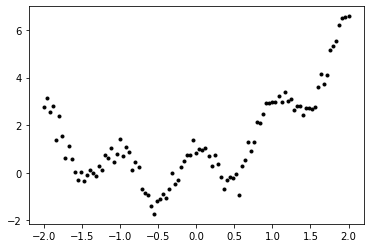

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Generate the features
x = torch.linspace(-2,2,101).reshape(-1,1)

# Generate the response variables 
y_obs = x**2 + x + torch.cos(2*np.pi*x) + torch.randn_like(x)*0.3

plt.plot(x,y_obs,'k.')

We'd like to find a function that fits this data.  One way to do this is, of course, linear regression, but that requires specifying the form of the design matrix.  As we saw in lecture, we'd like to learn the design matrix from the data.  We'll use a neural network to perform this task.  Algebraically, we can specify the neural network via the following sequentially applied functions.
$$
\underbrace{z}_{m\times p} = \underbrace{x}_{m\times 1} \underbrace{W^{(1)}}_{1\times p} + \underbrace{b^{(1)}}_{1\times p}
$$
$$
h = \sigma(z)
$$
$$
\underbrace{y}_{m\times 1} = h \underbrace{W^{(2)}}{p \times 1} + \underbrace{b^{(2)}}_{1\times 1}
$$

Because this is getting a bit complicated, let's develop a create a class for this neural network to hold weights and apply functions as appropriate.    

In [2]:
class NeuralNet(object):
    
    def __init__(self,n,p,N):
        self.n = n   # Number of features (1 for univariate problem)
        self.p = p   # Number of nodes in the hidden layer
        self.N = N   # Number of outputs (1 for the regression problem)
        
        # Instantiate weight matrices 
        self.W_1 = torch.randn(n,p)*10
        self.W_2 = torch.randn(p,N)/np.sqrt(p)*1
        
        # Instantiate bias vectors (Why do we need this?)
        self.b_1 = torch.randn(1,p)*10
        self.b_2 = torch.randn(1,N)/np.sqrt(p)*1
               
    def forward(self,X):
        # Applies the neural network model
        ## All of these self. prefixes save calculation results
        ## as class variables - we can inspect them later if we
        ## wish to
        self.X = X
        self.z = self.X @ self.W_1 + self.b_1  # First linear 
        self.h = torch.sigmoid(self.z)         # Activation
        self.y = self.h @ self.W_2 + self.b_2  # Second linear
        
        return self.y


You'll notice that we're instantiating weights randomly.  Let's see what type of functions this model produces, prior to training.  It's interesting to see what the effect is of messing with the variance of the weights when initializing them.   

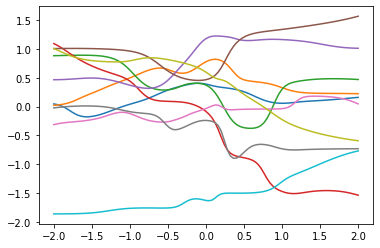

In [3]:
# Sample 10 random neural nets
for i in range(10):
    
    # Create the neural network
    net = NeuralNet(1,20,1)
    
    # Make a prediction
    y_pred = net.forward(x)
    
    # Plot the predictions
    plt.plot(x,y_pred)


Of course, this isn't all that interesting on its own.  We now need to train this thing.  We'll do this using gradient descent, and herein lies the power of pytorch.  It is a framework for *automatic differentiation*.  What does this mean?  It means that it keeps a record of all of the operations that have been done to produce the output of a given function.  It then can *automaticall* apply the chain rule to produce derivatives of a function with respect to anything that was used to compute it.  Here, we're hoping to take the gradient with respect to the weights and biases.  We can tell pytorch that we're going to want these things by using the "requires_grad_" flag.  

In [4]:
class NeuralNet(object):
    
    def __init__(self,n,p,N):
        self.n = n   # Number of features (1 for univariate problem)
        self.p = p   # Number of nodes in the hidden layer
        self.N = N   # Number of outputs (1 for the regression problem)
        
        # Instantiate weight matrices 
        self.W_1 = torch.randn(n,p)*10
        self.W_2 = torch.randn(p,N)/np.sqrt(p)
        
        # Instantiate bias vectors (Why do we need this?)
        self.b_1 = torch.randn(1,p)*10
        self.b_2 = torch.randn(1,N)/np.sqrt(p)
        
        ### CHANGE FROM ABOVE ###  
        # Collect the model parameters, and tell pytorch to
        # collect gradient information about them.
        self.parameters = [self.W_1,self.W_2,self.b_1,self.b_2]
        for param in self.parameters:
            param.requires_grad_()
    def forward(self,X):
        # Applies the neural network model
        ## All of these self. prefixes save calculation results
        ## as class variables - we can inspect them later if we
        ## wish to
        self.X = X
        self.z = self.X @ self.W_1 + self.b_1  # First linear 
        self.h = torch.sigmoid(self.z)         # Activation
        self.y = self.h @ self.W_2 + self.b_2  # Second linear
        return self.y
    
    def zero_grad(self):
        ### Each parameter has an additional array associated
        ### with it to store its gradient.  This is not 
        ### automatically cleared, so we have a method to
        ### clear it.
        for param in self.parameters:
            try:
                param.grad.data[:] = 0.0
            except AttributeError:
                pass
        

One thing that still need is something to minimize.  Since this is a regression problem, we'll use mean-squared-error

In [5]:
def mse(y_pred,y_obs):
    m = y_pred.shape[0]
    return 1./m*((y_pred-y_obs)**2).sum()

Now, the code for gradient descent becomes strikingly simple:

In [6]:
net = NeuralNet(1,20,1)  # Instantiate network
eta = 1e-1               # Set learning rate (empirically derived)
for t in range(50000):   # run for 50000 epochs
    y_pred = net.forward(x)   # Make a prediction
    L = mse(y_pred,y_obs)     # Compute mse
    net.zero_grad()           # Clear gradient buffer
    L.backward()              # MAGIC: compute dL/d parameter
    for param in net.parameters:            # update parameters w/
        param.data -= eta*param.grad.data   # GD
        
    if t%100==0:         # Print loss    
        print(t,L.item())
    
        


0 5.691147327423096
100 0.570213794708252
200 0.3734928071498871
300 0.24961869418621063
400 0.19454820454120636
500 0.16557841002941132
600 0.14755000174045563
700 0.13552922010421753
800 0.12712223827838898
900 0.12095434963703156
1000 0.11620838940143585
1100 0.11239505559206009
1200 0.10921740531921387
1300 0.10649137198925018
1400 0.10409920662641525
1500 0.10196343064308167
1600 0.10003140568733215
1700 0.09826663881540298
1800 0.09664277732372284
1900 0.09514085203409195
2000 0.0937466099858284
2100 0.09244918823242188
2200 0.09123985469341278
2300 0.09011170268058777
2400 0.08905880898237228
2500 0.08807571977376938
2600 0.08715761452913284
2700 0.0862998217344284
2800 0.08549783378839493
2900 0.08474767208099365
3000 0.08404526114463806
3100 0.08338665962219238
3200 0.08276841789484024
3300 0.08218712359666824
3400 0.08163957297801971
3500 0.08112286031246185
3600 0.08063436299562454
3700 0.08017165958881378
3800 0.07973230630159378
3900 0.07931442558765411
4000 0.078916311264

32300 0.06648080796003342
32400 0.06647782772779465
32500 0.0664748102426529
32600 0.06647185236215591
32700 0.06646887212991714
32800 0.06646586954593658
32900 0.06646288931369781
33000 0.06645993143320084
33100 0.06645698100328445
33200 0.06645400077104568
33300 0.0664510726928711
33400 0.0664481371641159
33500 0.06644521653652191
33600 0.06644228845834732
33700 0.06643937528133392
33800 0.06643646210432053
33900 0.06643359363079071
34000 0.06643068790435791
34100 0.0664278119802475
34200 0.0664249137043953
34300 0.06642204523086548
34400 0.06641918420791626
34500 0.06641631573438644
34600 0.0664135068655014
34700 0.06641064584255219
34800 0.06640778481960297
34900 0.06640499085187912
35000 0.0664021447300911
35100 0.06639932096004486
35200 0.06639648973941803
35300 0.0663936510682106
35400 0.06639083474874496
35500 0.06638804078102112
35600 0.06638526916503906
35700 0.06638243794441223
35800 0.06637963652610779
35900 0.06637684255838394
36000 0.0663740485906601
36100 0.0663712918758

Now we can plot our model prediction versus observations.  Pretty good!  And no manual selection of basis functions.

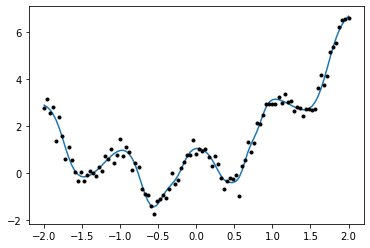

In [7]:
plt.plot(x.detach().squeeze(),y_pred.detach().squeeze())
plt.plot(x.detach().squeeze(),y_obs.detach().squeeze(),'k.')

## Applying an MLP to MNIST:
Train a neural on MNIST using pytorch.  You should use the above code as a template.  Things you'll need to change: $n$ will no longer be 1, but rather 784.  $N$ will no longer be one, but 10.  You'll want to adjust $p$, the number of hidden layer nodes.  You'll likely need to adjust the learning rate.  Finally, and most importantly, you'll need to use a different loss function.  In particular, you'll replace our handrolled MSE code with [this](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).  IMPORTANT NOTE: this loss expects *logits* as inputs, which is to say that it will do softmax for you internally.  As such, the architecture of your network should be more or less the same as above.  

In [8]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X[:5000]
y = y[:5000]

In [9]:
X -= X.mean()
X /= X.std()

In [10]:

class NeuralNet(object):
    
    def __init__(self,n,p,N):
        self.n = n   # Number of features (1 for univariate problem)
        self.p = p   # Number of nodes in the hidden layer
        self.N = N   # Number of outputs (1 for the regression problem)
        
        # Instantiate weight matrices 
        self.W_1 = torch.randn(n,p)*1e-3
        self.W_2 = torch.randn(p,N)*1e-3
        
        # Instantiate bias vectors (Why do we need this?)
        self.b_1 = torch.randn(1,p)
        self.b_2 = torch.randn(1,N)
        
        ### CHANGE FROM ABOVE ###  
        # Collect the model parameters, and tell pytorch to
        # collect gradient information about them.
        self.parameters = [self.W_1,self.W_2,self.b_1,self.b_2]
        for param in self.parameters:
            param.requires_grad_()
    def forward(self,X):
        # Applies the neural network model
        ## All of these self. prefixes save calculation results
        ## as class variables - we can inspect them later if we
        ## wish to
        self.X = X
        self.z = self.X @ self.W_1 + self.b_1  # First linear 
        self.h = torch.sigmoid(self.z)         # Activation
        self.y = self.h @ self.W_2 + self.b_2  # Second linear
        return self.y
    
    def zero_grad(self):
        ### Each parameter has an additional array associated
        ### with it to store its gradient.  This is not 
        ### automatically cleared, so we have a method to
        ### clear it.
        for param in self.parameters:
            try:
                param.grad.data[:] = 0.0
            except AttributeError:
                pass
        

In [11]:
import torch
X_train = torch.from_numpy(X).to(torch.float)
y_train = torch.from_numpy(y.astype(int)).to(torch.long)

In [ ]:
net = NeuralNet(784,200,10)  # Instantiate network
eta = 1e-2               # Set learning rate (empirically derived)
loss = torch.nn.CrossEntropyLoss()
for t in range(50000):   # run for 50000 epochs
    y_pred = net.forward(X_train)   # Make a prediction
    L = loss(y_pred,y_train)     # Compute mse
    net.zero_grad()           # Clear gradient buffer
    L.backward()              # MAGIC: compute dL/d parameter
    for param in net.parameters:            # update parameters w/
        param.data -= eta*param.grad.data   # GD
        
    if t%10==0:         # Print loss    
        print(t,L.item(),(torch.argmax(y_pred,axis=1)==y_train).sum()/len(y_train))
        
    

0 2.7757482528686523 tensor(0.1002)
10 2.461261510848999 tensor(0.1002)
20 2.3602213859558105 tensor(0.1002)
30 2.320316791534424 tensor(0.1100)
40 2.3056278228759766 tensor(0.1100)
50 2.3004231452941895 tensor(0.1100)
60 2.2983598709106445 tensor(0.1100)
70 2.2972569465637207 tensor(0.1976)
80 2.296435832977295 tensor(0.1396)
90 2.29569411277771 tensor(0.1186)
100 2.2949721813201904 tensor(0.1148)
110 2.294250726699829 tensor(0.1146)
120 2.293524980545044 tensor(0.1158)
130 2.2927918434143066 tensor(0.1158)
140 2.2920498847961426 tensor(0.1162)
150 2.291299819946289 tensor(0.1174)
160 2.290539503097534 tensor(0.1186)
170 2.289768695831299 tensor(0.1194)
180 2.2889866828918457 tensor(0.1204)
190 2.2881927490234375 tensor(0.1212)
200 2.287386178970337 tensor(0.1222)
210 2.2865660190582275 tensor(0.1232)
220 2.2857308387756348 tensor(0.1236)
230 2.284881353378296 tensor(0.1244)
240 2.28401517868042 tensor(0.1260)
250 2.283132314682007 tensor(0.1266)
260 2.282230854034424 tensor(0.1280)
2

2150 0.8705199360847473 tensor(0.7678)
2160 0.8656215071678162 tensor(0.7706)
2170 0.8607704043388367 tensor(0.7716)
2180 0.855965793132782 tensor(0.7730)
2190 0.8512074947357178 tensor(0.7760)
2200 0.8464946150779724 tensor(0.7780)
2210 0.8418266773223877 tensor(0.7794)
2220 0.8372028470039368 tensor(0.7802)
2230 0.8326228260993958 tensor(0.7814)
2240 0.8280861377716064 tensor(0.7824)
2250 0.8235923051834106 tensor(0.7848)
2260 0.8191405534744263 tensor(0.7862)
2270 0.8147306442260742 tensor(0.7880)
2280 0.8103621006011963 tensor(0.7902)
2290 0.8060344457626343 tensor(0.7920)
2300 0.80174720287323 tensor(0.7932)
2310 0.7975000143051147 tensor(0.7938)
2320 0.7932923436164856 tensor(0.7944)
2330 0.789124071598053 tensor(0.7964)
2340 0.7849944233894348 tensor(0.7990)
2350 0.7809032797813416 tensor(0.8012)
2360 0.7768502235412598 tensor(0.8022)
2370 0.7728349566459656 tensor(0.8032)
2380 0.7688570022583008 tensor(0.8056)
2390 0.764916181564331 tensor(0.8076)
2400 0.7610118985176086 tensor

4250 0.4111250042915344 tensor(0.8976)
4260 0.41028741002082825 tensor(0.8976)
4270 0.40945494174957275 tensor(0.8978)
4280 0.4086277484893799 tensor(0.8978)
4290 0.4078057110309601 tensor(0.8976)
4300 0.40698879957199097 tensor(0.8976)
4310 0.40617692470550537 tensor(0.8984)
4320 0.40537014603614807 tensor(0.8986)
4330 0.40456828474998474 tensor(0.8988)
4340 0.40377140045166016 tensor(0.8990)
4350 0.40297943353652954 tensor(0.8992)
4360 0.4021921753883362 tensor(0.8992)
4370 0.4014098048210144 tensor(0.8992)
4380 0.4006321430206299 tensor(0.8996)
4390 0.3998591899871826 tensor(0.9000)
4400 0.3990910053253174 tensor(0.9000)
4410 0.3983272910118103 tensor(0.9000)
4420 0.3975682556629181 tensor(0.9004)
4430 0.3968137800693512 tensor(0.9006)
4440 0.3960636854171753 tensor(0.9010)
4450 0.3953181505203247 tensor(0.9010)
4460 0.3945769667625427 tensor(0.9014)
4470 0.3938402533531189 tensor(0.9014)
4480 0.3931078314781189 tensor(0.9016)
4490 0.39237961173057556 tensor(0.9016)
4500 0.391655772

6340 0.3044722080230713 tensor(0.9200)
6350 0.3041553497314453 tensor(0.9200)
6360 0.30383962392807007 tensor(0.9200)
6370 0.303524911403656 tensor(0.9200)
6380 0.3032112419605255 tensor(0.9200)
6390 0.3028985857963562 tensor(0.9200)
6400 0.30258697271347046 tensor(0.9200)
6410 0.3022764027118683 tensor(0.9200)
6420 0.3019667863845825 tensor(0.9200)
6430 0.3016582429409027 tensor(0.9200)
6440 0.3013506531715393 tensor(0.9204)
6450 0.30104416608810425 tensor(0.9204)
6460 0.3007386326789856 tensor(0.9204)
6470 0.30043402314186096 tensor(0.9204)
6480 0.3001304566860199 tensor(0.9206)
6490 0.29982784390449524 tensor(0.9206)
6500 0.299526184797287 tensor(0.9206)
6510 0.29922550916671753 tensor(0.9206)
6520 0.2989257574081421 tensor(0.9206)
6530 0.2986270487308502 tensor(0.9208)
6540 0.2983292043209076 tensor(0.9210)
6550 0.29803231358528137 tensor(0.9212)
6560 0.29773637652397156 tensor(0.9212)
6570 0.2974413335323334 tensor(0.9212)
6580 0.29714730381965637 tensor(0.9214)
6590 0.29685413837

8430 0.25437116622924805 tensor(0.9322)
8440 0.2541859745979309 tensor(0.9324)
8450 0.2540012001991272 tensor(0.9324)
8460 0.25381678342819214 tensor(0.9324)
8470 0.25363269448280334 tensor(0.9326)
8480 0.2534489929676056 tensor(0.9326)
8490 0.2532656788825989 tensor(0.9326)
8500 0.25308266282081604 tensor(0.9328)
8510 0.25290000438690186 tensor(0.9330)
8520 0.2527177631855011 tensor(0.9328)
8530 0.25253579020500183 tensor(0.9328)
8540 0.252354234457016 tensor(0.9326)
8550 0.2521730363368988 tensor(0.9326)
8560 0.2519921064376831 tensor(0.9326)
8570 0.25181159377098083 tensor(0.9326)
8580 0.25163140892982483 tensor(0.9326)
8590 0.2514515519142151 tensor(0.9326)
8600 0.2512720823287964 tensor(0.9326)
8610 0.2510928809642792 tensor(0.9326)
8620 0.250914067029953 tensor(0.9328)
8630 0.2507356107234955 tensor(0.9328)
8640 0.25055742263793945 tensor(0.9328)
8650 0.25037965178489685 tensor(0.9328)
8660 0.25020211935043335 tensor(0.9328)
8670 0.25002503395080566 tensor(0.9328)
8680 0.24984817

10490 0.22223390638828278 tensor(0.9408)
10500 0.22210092842578888 tensor(0.9408)
10510 0.22196806967258453 tensor(0.9408)
10520 0.2218354046344757 tensor(0.9408)
10530 0.2217029482126236 tensor(0.9408)
10540 0.22157062590122223 tensor(0.9408)
10550 0.2214384824037552 tensor(0.9408)
10560 0.22130654752254486 tensor(0.9408)
10570 0.22117473185062408 tensor(0.9408)
10580 0.22104309499263763 tensor(0.9406)
10590 0.2209116667509079 tensor(0.9406)
10600 0.22078034281730652 tensor(0.9406)
10610 0.22064921259880066 tensor(0.9406)
10620 0.2205182909965515 tensor(0.9406)
10630 0.2203875184059143 tensor(0.9406)
10640 0.22025687992572784 tensor(0.9406)
10650 0.2201264351606369 tensor(0.9406)
10660 0.21999616920948029 tensor(0.9406)
10670 0.21986602246761322 tensor(0.9408)
10680 0.21973605453968048 tensor(0.9408)
10690 0.21960629522800446 tensor(0.9408)
10700 0.21947668492794037 tensor(0.9408)
10710 0.21934723854064941 tensor(0.9408)
10720 0.2192179411649704 tensor(0.9408)
10730 0.2190887629985809

12510 0.19830763339996338 tensor(0.9472)
12520 0.1982014775276184 tensor(0.9472)
12530 0.19809536635875702 tensor(0.9472)
12540 0.19798937439918518 tensor(0.9472)
12550 0.1978834867477417 tensor(0.9472)
12560 0.19777774810791016 tensor(0.9472)
12570 0.1976720243692398 tensor(0.9472)
12580 0.1975664496421814 tensor(0.9474)
12590 0.19746093451976776 tensor(0.9474)
12600 0.19735556840896606 tensor(0.9474)
12610 0.19725027680397034 tensor(0.9474)
12620 0.19714507460594177 tensor(0.9474)
12630 0.19704002141952515 tensor(0.9474)
12640 0.1969350129365921 tensor(0.9474)
12650 0.19683010876178741 tensor(0.9476)
12660 0.19672533869743347 tensor(0.9476)
12670 0.1966206133365631 tensor(0.9476)
12680 0.1965160220861435 tensor(0.9476)
12690 0.19641150534152985 tensor(0.9476)
12700 0.19630710780620575 tensor(0.9476)
12710 0.19620276987552643 tensor(0.9476)
12720 0.19609856605529785 tensor(0.9476)
12730 0.19599445164203644 tensor(0.9476)
12740 0.1958904266357422 tensor(0.9476)
12750 0.1957865059375763

14530 0.17863817512989044 tensor(0.9528)
14540 0.17854857444763184 tensor(0.9528)
14550 0.178459033370018 tensor(0.9526)
14560 0.17836956679821014 tensor(0.9526)
14570 0.17828014492988586 tensor(0.9526)
14580 0.17819081246852875 tensor(0.9526)
14590 0.1781015694141388 tensor(0.9526)
14600 0.17801234126091003 tensor(0.9526)
14610 0.17792321741580963 tensor(0.9526)
14620 0.1778341382741928 tensor(0.9528)
14630 0.17774513363838196 tensor(0.9528)
14640 0.1776561588048935 tensor(0.9528)
14650 0.17756733298301697 tensor(0.9530)
14660 0.17747849225997925 tensor(0.9530)
14670 0.17738977074623108 tensor(0.9530)
14680 0.1773010790348053 tensor(0.9530)
14690 0.17721247673034668 tensor(0.9530)
14700 0.17712393403053284 tensor(0.9530)
14710 0.17703545093536377 tensor(0.9530)
14720 0.17694702744483948 tensor(0.9530)
14730 0.17685867846012115 tensor(0.9530)
14740 0.1767704039812088 tensor(0.9530)
14750 0.17668218910694122 tensor(0.9530)
14760 0.17659401893615723 tensor(0.9530)
14770 0.176505938172340

16550 0.16176696121692657 tensor(0.9574)
16560 0.16168899834156036 tensor(0.9574)
16570 0.16161110997200012 tensor(0.9576)
16580 0.16153322160243988 tensor(0.9578)
16590 0.1614554226398468 tensor(0.9580)
16600 0.1613776683807373 tensor(0.9580)
16610 0.16129998862743378 tensor(0.9580)
16620 0.16122230887413025 tensor(0.9580)
16630 0.16114473342895508 tensor(0.9580)
16640 0.1610671579837799 tensor(0.9580)
16650 0.1609896719455719 tensor(0.9580)
16660 0.16091220080852509 tensor(0.9582)
16670 0.16083480417728424 tensor(0.9584)
16680 0.16075745224952698 tensor(0.9584)
16690 0.1606801450252533 tensor(0.9584)
16700 0.16060283780097961 tensor(0.9584)
16710 0.16052566468715668 tensor(0.9584)
16720 0.16044849157333374 tensor(0.9584)
16730 0.16037137806415558 tensor(0.9584)
16740 0.160294309258461 tensor(0.9584)
16750 0.1602173000574112 tensor(0.9584)
16760 0.16014033555984497 tensor(0.9584)
16770 0.16006340086460114 tensor(0.9584)
16780 0.15998654067516327 tensor(0.9584)
16790 0.1599097102880478

18570 0.14695905148983002 tensor(0.9632)
18580 0.14689013361930847 tensor(0.9632)
18590 0.14682120084762573 tensor(0.9632)
18600 0.14675235748291016 tensor(0.9632)
18610 0.14668351411819458 tensor(0.9632)
18620 0.14661473035812378 tensor(0.9632)
18630 0.14654599130153656 tensor(0.9632)
18640 0.14647728204727173 tensor(0.9632)
18650 0.14640860259532928 tensor(0.9632)
18660 0.14633995294570923 tensor(0.9632)
18670 0.14627139270305634 tensor(0.9634)
18680 0.14620284736156464 tensor(0.9634)
18690 0.14613433182239532 tensor(0.9634)
18700 0.1460658460855484 tensor(0.9634)
18710 0.14599743485450745 tensor(0.9634)
18720 0.14592903852462769 tensor(0.9634)
18730 0.1458606868982315 tensor(0.9634)
18740 0.1457923799753189 tensor(0.9634)
18750 0.1457241028547287 tensor(0.9634)
18760 0.14565587043762207 tensor(0.9634)
18770 0.14558766782283783 tensor(0.9634)
18780 0.14551950991153717 tensor(0.9634)
18790 0.1454513967037201 tensor(0.9634)
18800 0.1453833132982254 tensor(0.9634)
18810 0.14531528949737

20590 0.13379542529582977 tensor(0.9678)
20600 0.133733868598938 tensor(0.9678)
20610 0.1336723119020462 tensor(0.9678)
20620 0.1336108297109604 tensor(0.9678)
20630 0.13354934751987457 tensor(0.9678)
20640 0.13348792493343353 tensor(0.9678)
20650 0.13342656195163727 tensor(0.9678)
20660 0.13336516916751862 tensor(0.9678)
20670 0.13330385088920593 tensor(0.9678)
20680 0.13324253261089325 tensor(0.9678)
20690 0.13318128883838654 tensor(0.9678)
20700 0.13312003016471863 tensor(0.9678)
20710 0.1330588310956955 tensor(0.9678)
20720 0.13299767673015594 tensor(0.9678)
20730 0.13293656706809998 tensor(0.9678)
20740 0.132875457406044 tensor(0.9678)
20750 0.13281437754631042 tensor(0.9678)
20760 0.13275332748889923 tensor(0.9678)
20770 0.132692351937294 tensor(0.9678)
20780 0.13263139128684998 tensor(0.9678)
20790 0.13257043063640594 tensor(0.9678)
20800 0.1325095295906067 tensor(0.9678)
20810 0.1324486881494522 tensor(0.9678)
20820 0.13238784670829773 tensor(0.9678)
20830 0.13232703506946564 t

22610 0.12200627475976944 tensor(0.9722)
22620 0.12195099890232086 tensor(0.9722)
22630 0.12189575284719467 tensor(0.9722)
22640 0.12184052914381027 tensor(0.9722)
22650 0.12178532779216766 tensor(0.9722)
22660 0.12173016369342804 tensor(0.9722)
22670 0.1216750368475914 tensor(0.9722)
22680 0.12161993235349655 tensor(0.9722)
22690 0.1215648427605629 tensor(0.9722)
22700 0.12150980532169342 tensor(0.9722)
22710 0.12145476043224335 tensor(0.9722)
22720 0.12139976769685745 tensor(0.9722)
22730 0.12134481221437454 tensor(0.9722)
22740 0.12128987908363342 tensor(0.9722)
22750 0.12123497575521469 tensor(0.9722)
22760 0.12118008732795715 tensor(0.9722)
22770 0.12112525850534439 tensor(0.9722)
22780 0.12107043713331223 tensor(0.9722)
22790 0.12101562321186066 tensor(0.9722)
22800 0.12096086144447327 tensor(0.9722)
22810 0.12090615183115005 tensor(0.9722)
22820 0.12085141241550446 tensor(0.9722)
22830 0.12079675495624542 tensor(0.9722)
22840 0.12074211239814758 tensor(0.9722)
22850 0.1206874772

24620 0.11145210266113281 tensor(0.9756)
24630 0.11140225827693939 tensor(0.9756)
24640 0.11135245114564896 tensor(0.9758)
24650 0.1113026887178421 tensor(0.9758)
24660 0.11125294119119644 tensor(0.9758)
24670 0.11120320856571198 tensor(0.9758)
24680 0.1111535131931305 tensor(0.9758)
24690 0.1111038476228714 tensor(0.9758)
24700 0.1110541895031929 tensor(0.9758)
24710 0.11100459098815918 tensor(0.9758)
24720 0.11095497012138367 tensor(0.9758)
24730 0.11090540885925293 tensor(0.9758)
24740 0.110855832695961 tensor(0.9758)
24750 0.11080634593963623 tensor(0.9758)
24760 0.11075685173273087 tensor(0.9758)
24770 0.1107073500752449 tensor(0.9758)
24780 0.1106579378247261 tensor(0.9758)
24790 0.11060851067304611 tensor(0.9758)
24800 0.11055910587310791 tensor(0.9760)
24810 0.11050973832607269 tensor(0.9760)
24820 0.11046038568019867 tensor(0.9760)
24830 0.11041108518838882 tensor(0.9760)
24840 0.11036179214715958 tensor(0.9760)
24850 0.11031251400709152 tensor(0.9760)
24860 0.1102632656693458

26630 0.10192921757698059 tensor(0.9782)
26640 0.10188422352075577 tensor(0.9782)
26650 0.10183923691511154 tensor(0.9782)
26660 0.10179426521062851 tensor(0.9782)
26670 0.10174934566020966 tensor(0.9782)
26680 0.1017044261097908 tensor(0.9782)
26690 0.10165953636169434 tensor(0.9782)
26700 0.10161468386650085 tensor(0.9782)
26710 0.10156983882188797 tensor(0.9782)
26720 0.10152500867843628 tensor(0.9782)
26730 0.10148021578788757 tensor(0.9782)
26740 0.10143544524908066 tensor(0.9782)
26750 0.10139069706201553 tensor(0.9782)
26760 0.101345956325531 tensor(0.9782)
26770 0.10130123794078827 tensor(0.9782)
26780 0.10125656425952911 tensor(0.9782)
26790 0.10121190547943115 tensor(0.9782)
26800 0.10116726905107498 tensor(0.9784)
26810 0.1011226549744606 tensor(0.9784)
26820 0.10107805579900742 tensor(0.9786)
26830 0.10103348642587662 tensor(0.9786)
26840 0.10098892450332642 tensor(0.9786)
26850 0.1009443998336792 tensor(0.9786)
26860 0.10089989006519318 tensor(0.9786)
26870 0.1008554100990

28640 0.09332222491502762 tensor(0.9812)
28650 0.09328152239322662 tensor(0.9812)
28660 0.09324084222316742 tensor(0.9812)
28670 0.09320017695426941 tensor(0.9812)
28680 0.093159519135952 tensor(0.9812)
28690 0.09311891347169876 tensor(0.9812)
28700 0.09307832270860672 tensor(0.9812)
28710 0.09303773939609528 tensor(0.9812)
28720 0.09299717843532562 tensor(0.9812)
28730 0.09295663982629776 tensor(0.9812)
28740 0.09291611611843109 tensor(0.9812)
28750 0.09287562221288681 tensor(0.9812)
28760 0.09283514320850372 tensor(0.9812)
28770 0.09279467910528183 tensor(0.9812)
28780 0.09275424480438232 tensor(0.9812)
28790 0.0927138403058052 tensor(0.9812)
28800 0.09267342835664749 tensor(0.9812)
28810 0.09263305366039276 tensor(0.9812)
28820 0.09259268641471863 tensor(0.9812)
28830 0.09255236387252808 tensor(0.9812)
28840 0.09251202642917633 tensor(0.9812)
28850 0.09247171878814697 tensor(0.9812)
28860 0.0924314484000206 tensor(0.9812)
28870 0.09239119291305542 tensor(0.9812)
28880 0.092350959777

30650 0.08553340286016464 tensor(0.9834)
30660 0.08549654483795166 tensor(0.9834)
30670 0.08545970916748047 tensor(0.9834)
30680 0.08542290329933167 tensor(0.9834)
30690 0.08538611233234406 tensor(0.9834)
30700 0.08534932881593704 tensor(0.9834)
30710 0.08531256765127182 tensor(0.9834)
30720 0.08527582138776779 tensor(0.9834)
30730 0.08523909747600555 tensor(0.9834)
30740 0.08520239591598511 tensor(0.9834)
30750 0.08516570180654526 tensor(0.9834)
30760 0.085129015147686 tensor(0.9834)
30770 0.08509237319231033 tensor(0.9834)
30780 0.08505574613809586 tensor(0.9834)
30790 0.08501912653446198 tensor(0.9834)
30800 0.08498254418373108 tensor(0.9834)
30810 0.08494594693183899 tensor(0.9834)
30820 0.08490937948226929 tensor(0.9834)
30830 0.08487284183502197 tensor(0.9834)
30840 0.08483631908893585 tensor(0.9834)
30850 0.08479979634284973 tensor(0.9834)
30860 0.08476331830024719 tensor(0.9834)
30870 0.08472683280706406 tensor(0.9834)
30880 0.08469037711620331 tensor(0.9834)
30890 0.0846539437

32660 0.07847783714532852 tensor(0.9852)
32670 0.07844443619251251 tensor(0.9852)
32680 0.0784110501408577 tensor(0.9852)
32690 0.07837767899036407 tensor(0.9852)
32700 0.07834434509277344 tensor(0.9852)
32710 0.0783110186457634 tensor(0.9852)
32720 0.07827770709991455 tensor(0.9852)
32730 0.0782444030046463 tensor(0.9852)
32740 0.07821112871170044 tensor(0.9854)
32750 0.07817784696817398 tensor(0.9854)
32760 0.07814459502696991 tensor(0.9854)
32770 0.07811135798692703 tensor(0.9854)
32780 0.07807814329862595 tensor(0.9854)
32790 0.07804494351148605 tensor(0.9854)
32800 0.07801175862550735 tensor(0.9854)
32810 0.07797858119010925 tensor(0.9856)
32820 0.07794543355703354 tensor(0.9856)
32830 0.07791227847337723 tensor(0.9856)
32840 0.0778791680932045 tensor(0.9856)
32850 0.07784607261419296 tensor(0.9856)
32860 0.07781298458576202 tensor(0.9856)
32870 0.07777991145849228 tensor(0.9856)
32880 0.07774685323238373 tensor(0.9856)
32890 0.07771381735801697 tensor(0.9856)
32900 0.077680788934

34670 0.07208216935396194 tensor(0.9878)
34680 0.07205188274383545 tensor(0.9878)
34690 0.07202162593603134 tensor(0.9878)
34700 0.07199138402938843 tensor(0.9878)
34710 0.07196114957332611 tensor(0.9880)
34720 0.07193093001842499 tensor(0.9880)
34730 0.07190072536468506 tensor(0.9880)
34740 0.07187053561210632 tensor(0.9882)
34750 0.07184037566184998 tensor(0.9882)
34760 0.07181020081043243 tensor(0.9882)
34770 0.07178005576133728 tensor(0.9882)
34780 0.07174992561340332 tensor(0.9882)
34790 0.07171981781721115 tensor(0.9882)
34800 0.07168970257043839 tensor(0.9882)
34810 0.0716596245765686 tensor(0.9882)
34820 0.07162955403327942 tensor(0.9882)
34830 0.07159951329231262 tensor(0.9882)
34840 0.07156945765018463 tensor(0.9882)
34850 0.07153943926095963 tensor(0.9882)
34860 0.07150942087173462 tensor(0.9882)
34870 0.0714794248342514 tensor(0.9882)
34880 0.07144942879676819 tensor(0.9882)
34890 0.07141946256160736 tensor(0.9882)
34900 0.07138951122760773 tensor(0.9882)
34910 0.0713595747

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(net.W_1[:,6].reshape(28,28).detach())